# Portfolio Diagnostic

c:\Users\Ale Leiva\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



Portfolio Weights:
  Slice    Weight
0  SWDA  0.423153
1  CNDX  0.149825
2  AMZN  0.060855
3  META  0.067931
4    MU  0.044438
5   RTX  0.049344
6  NVDA  0.052269
7    HD  0.052930
8   LMT  0.050476
9  CRWD  0.048778

Herfindahl Index: 0.2247

Top 3 Holdings:
  Slice    Weight
0  SWDA  0.423153
1  CNDX  0.149825
3  META  0.067931
Top 3 %: 0.6409


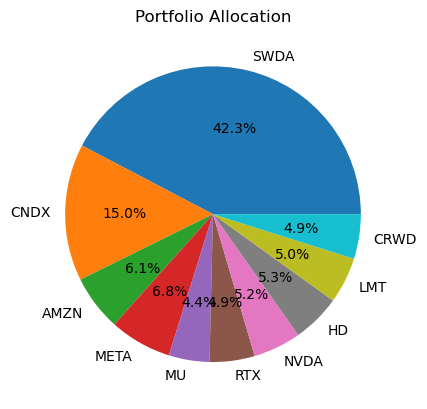

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load portfolio
df = pd.read_csv("../data/20260211_portfolio.csv")

df = df[df["Slice"] != "Total"]
df["Value"] = pd.to_numeric(df["Value"])

total_value = df["Value"].sum()
df["Weight"] = df["Value"] / total_value

print("\nPortfolio Weights:")
print(df[["Slice", "Weight"]])

# -----------------------------
# Concentration Risk
# -----------------------------

# Herfindahl Index
hhi = (df["Weight"]**2).sum()
print("\nHerfindahl Index:", round(hhi,4))

# Top 3 concentration
top3 = df.sort_values("Weight", ascending=False).head(3)
print("\nTop 3 Holdings:")
print(top3[["Slice","Weight"]])
print("Top 3 %:", round(top3["Weight"].sum(),4))

# -----------------------------
# Pie Chart
# -----------------------------

plt.figure()
plt.pie(df["Weight"], labels=df["Slice"], autopct="%1.1f%%")
plt.title("Portfolio Allocation")
plt.show()

## Portfolio Metrics

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Your tickers
tickers = ["SWDA.L","CNDX.L","AMZN","META","MU","RTX","NVDA","HD","LMT","CRWD"]

# MSCI World ETF as benchmark
benchmark = "URTH"

all_tickers = tickers + [benchmark]

prices = yf.download(all_tickers, period="3y")["Close"]
# print(prices.tail())

returns = prices.pct_change().dropna()
# returns.head()

# wEights from the portfolio
weights = df.set_index("Slice")["Weight"]

# Map to yf tickers
weights.index = ["SWDA.L","CNDX.L","AMZN","META","MU","RTX","NVDA","HD","LMT","CRWD"]

# Calculate portfolio returns
portfolio_returns = returns[tickers] @ weights
# portfolio_returns.head()

[*********************100%***********************]  11 of 11 completed


Ticker            AMZN       CNDX.L        CRWD          HD         LMT  \
Date                                                                      
2026-02-05  222.690002  1417.199951  377.160004  382.369995  609.179993   
2026-02-06  210.320007  1430.599976  395.500000  385.149994  623.580017   
2026-02-09  208.720001  1448.800049  408.040009  381.000000  638.289978   
2026-02-10  206.960007  1448.400024  413.390015  389.679993  629.559998   
2026-02-11  203.729904  1440.800049  407.839996  389.467499  627.750000   

Ticker            META          MU        NVDA         RTX  SWDA.L        URTH  
Date                                                                            
2026-02-05  670.210022  382.890015  171.880005  195.970001  9709.0  186.460007  
2026-02-06  661.460022  394.690002  185.410004  198.660004  9779.0  190.240005  
2026-02-09  677.219971  383.500000  190.039993  196.190002  9855.0  191.839996  
2026-02-10  670.719971  373.250000  188.539993  195.190002  9880.0  1

In [12]:
results = []

for ticker in tickers:
    
    r = returns[ticker]
    bench = returns[benchmark]
    
    vol = r.std() * np.sqrt(252)
    corr = r.corr(bench)
    beta = np.cov(r, bench)[0,1] / np.var(bench)
    
    # max drawdown
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum/peak - 1
    max_dd = dd.min()
    
    results.append([ticker, vol, beta, corr, max_dd])

risk_df = pd.DataFrame(results, columns=["Ticker","Vol","Beta","Corr_vs_MSCI","Max_Drawdown"])

risk_df.sort_values("Beta", ascending=False)

,Ticker,Vol,Beta,Corr_vs_MSCI,Max_Drawdown
4,MU,0.522417,2.171132,0.578301,-0.576290
6,NVDA,0.488675,2.121674,0.604148,-0.368810
9,CRWD,0.440381,1.714904,0.541871,-0.444371
3,META,0.356342,1.489278,0.581558,-0.341508
2,AMZN,0.308729,1.408276,0.634739,-0.308766
7,HD,0.213373,0.811680,0.529333,-0.217916
1,CNDX.L,0.180230,0.583479,0.450489,-0.224400
5,RTX,0.230718,0.536859,0.323790,-0.328362
0,SWDA.L,0.268811,0.345160,0.178673,-0.259998
8,LMT,0.215744,0.236803,0.152733,-0.317884


<Axes: title={'center': 'Beta vs MSCI World'}, xlabel='Ticker'>

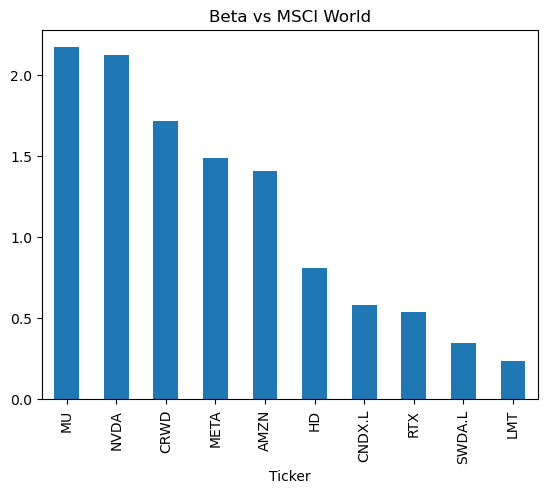

In [14]:
risk_df.sort_values("Beta", ascending=False).plot(
    x="Ticker", 
    y="Beta", 
    kind="bar",
    legend=False,
    title="Beta vs MSCI World"
)

In [35]:
import plotly.graph_objects as go

# Merge weights with risk metrics
plot_data = risk_df.copy()
plot_data["Weight"] = plot_data["Ticker"].map(weights)
plot_data["Weight_pct"] = plot_data["Weight"] * 100

# Remove MSCI index (SWDA.L) - analyze individual names only
plot_data = plot_data[plot_data["Ticker"] != "SWDA.L"]

# Calculate MSCI World benchmark metrics
bench = returns[benchmark]
msci_vol = bench.std() * np.sqrt(252)
msci_beta = 1.0  # By definition, benchmark has beta of 1

# Create bubble plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=plot_data["Beta"],
    y=plot_data["Vol"],
    mode='markers',
    marker=dict(
        size=plot_data["Weight"] * 500,  # Scale weights for visibility
        color=plot_data["Corr_vs_MSCI"],  # Color by correlation
        colorscale="RdYlGn_r",  # Red-Yellow-Green reversed
        showscale=True,
        colorbar=dict(title="Correlation<br>vs MSCI"),
        line=dict(width=2, color="white"),
        opacity=0.8
    ),
    text=[f"<b>{ticker}</b><br>Beta: {beta:.2f}<br>Vol: {vol:.2%}<br>Weight: {w:.2%}<br>Correlation: {corr:.2f}" 
          for ticker, beta, vol, w, corr in 
          zip(plot_data["Ticker"], plot_data["Beta"], plot_data["Vol"], 
              plot_data["Weight"], plot_data["Corr_vs_MSCI"])],
    hovertemplate="%{text}<extra></extra>",
    textposition="top center"
))

# Add benchmark reference lines
fig.add_hline(y=msci_vol, line_dash="dash", line_color="gray", 
              annotation_text="MSCI Vol", annotation_position="right")

fig.add_vline(x=msci_beta, line_dash="dash", line_color="gray",
              annotation_text="MSCI Beta", annotation_position="top")

fig.update_layout(
    title={
        "text": "<b>Portfolio Risk Profile</b><br><sub>Bubble size = Portfolio Weight | Color = Correlation to MSCI World</sub>",
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 20}
    },
    xaxis_title="<b>Beta vs MSCI World</b>",
    yaxis_title="<b>Volatility (Annualized)</b>",
    width=1400,  # Rectangular for PowerPoint
    height=700,
    template="plotly_white",
    font=dict(size=12, family="Arial"),
    hovermode="closest",
    plot_bgcolor="rgba(240,240,240,0.5)",
    yaxis_tickformat=".0%",
)

fig.show()

# Export as SVG
#fig.write_image("risk_beta.svg", format="svg", width=1400, height=700, scale=2)

In [ ]:
import plotly.graph_objects as go

# Merge weights with risk metrics
plot_data = risk_df.copy()
plot_data["Weight"] = plot_data["Ticker"].map(weights)
plot_data["Weight_pct"] = plot_data["Weight"] * 100

# Remove MSCI index (SWDA.L) - analyze individual names only
plot_data = plot_data[plot_data["Ticker"] != "SWDA.L"]

# Calculate MSCI World benchmark metrics
bench = returns[benchmark]
msci_vol = bench.std() * np.sqrt(252)
msci_beta = 1.0  # By definition, benchmark has beta of 1

# Create bubble plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=plot_data["Beta"],
    y=plot_data["Vol"],
    mode='markers',
    marker=dict(
        size=plot_data["Weight"] * 500,  # Scale weights for visibility
        color=plot_data["Corr_vs_MSCI"],  # Color by correlation
        colorscale="RdYlGn_r",  # Red-Yellow-Green reversed
        showscale=True,
        colorbar=dict(title="Correlation<br>vs MSCI"),
        line=dict(width=2, color="white"),
        opacity=0.8
    ),
    text=[f"<b>{ticker}</b><br>Beta: {beta:.2f}<br>Vol: {vol:.2%}<br>Weight: {w:.2%}<br>Correlation: {corr:.2f}" 
          for ticker, beta, vol, w, corr in 
          zip(plot_data["Ticker"], plot_data["Beta"], plot_data["Vol"], 
              plot_data["Weight"], plot_data["Corr_vs_MSCI"])],
    hovertemplate="%{text}<extra></extra>",
    textposition="top center"
))

# Add benchmark reference lines
fig.add_hline(y=msci_vol, line_dash="dash", line_color="gray", 
              annotation_text="MSCI Vol", annotation_position="right")

fig.add_vline(x=msci_beta, line_dash="dash", line_color="gray",
              annotation_text="MSCI Beta", annotation_position="top")

fig.update_layout(
    title={
        "text": "<b>Portfolio Risk Profile</b><br><sub>Bubble size = Portfolio Weight | Color = Correlation to MSCI World</sub>",
        "x": 0.5,
        "xanchor": "center",
        "font": {"size": 20}
    },
    xaxis_title="<b>Beta vs MSCI World</b>",
    yaxis_title="<b>Volatility (Annualized)</b>",
    width=1400,  # Rectangular for PowerPoint
    height=700,
    template="plotly_white",
    font=dict(size=12, family="Arial"),
    hovermode="closest",
    plot_bgcolor="rgba(240,240,240,0.5)",
    yaxis_tickformat=".0%",
)

fig.show()

# Export as SVG
#fig.write_image("risk_beta.svg", format="svg", width=1400, height=700, scale=2)

✓ Exported: portfolio_risk_profile.svg
✓ Exported: portfolio_risk_profile.png


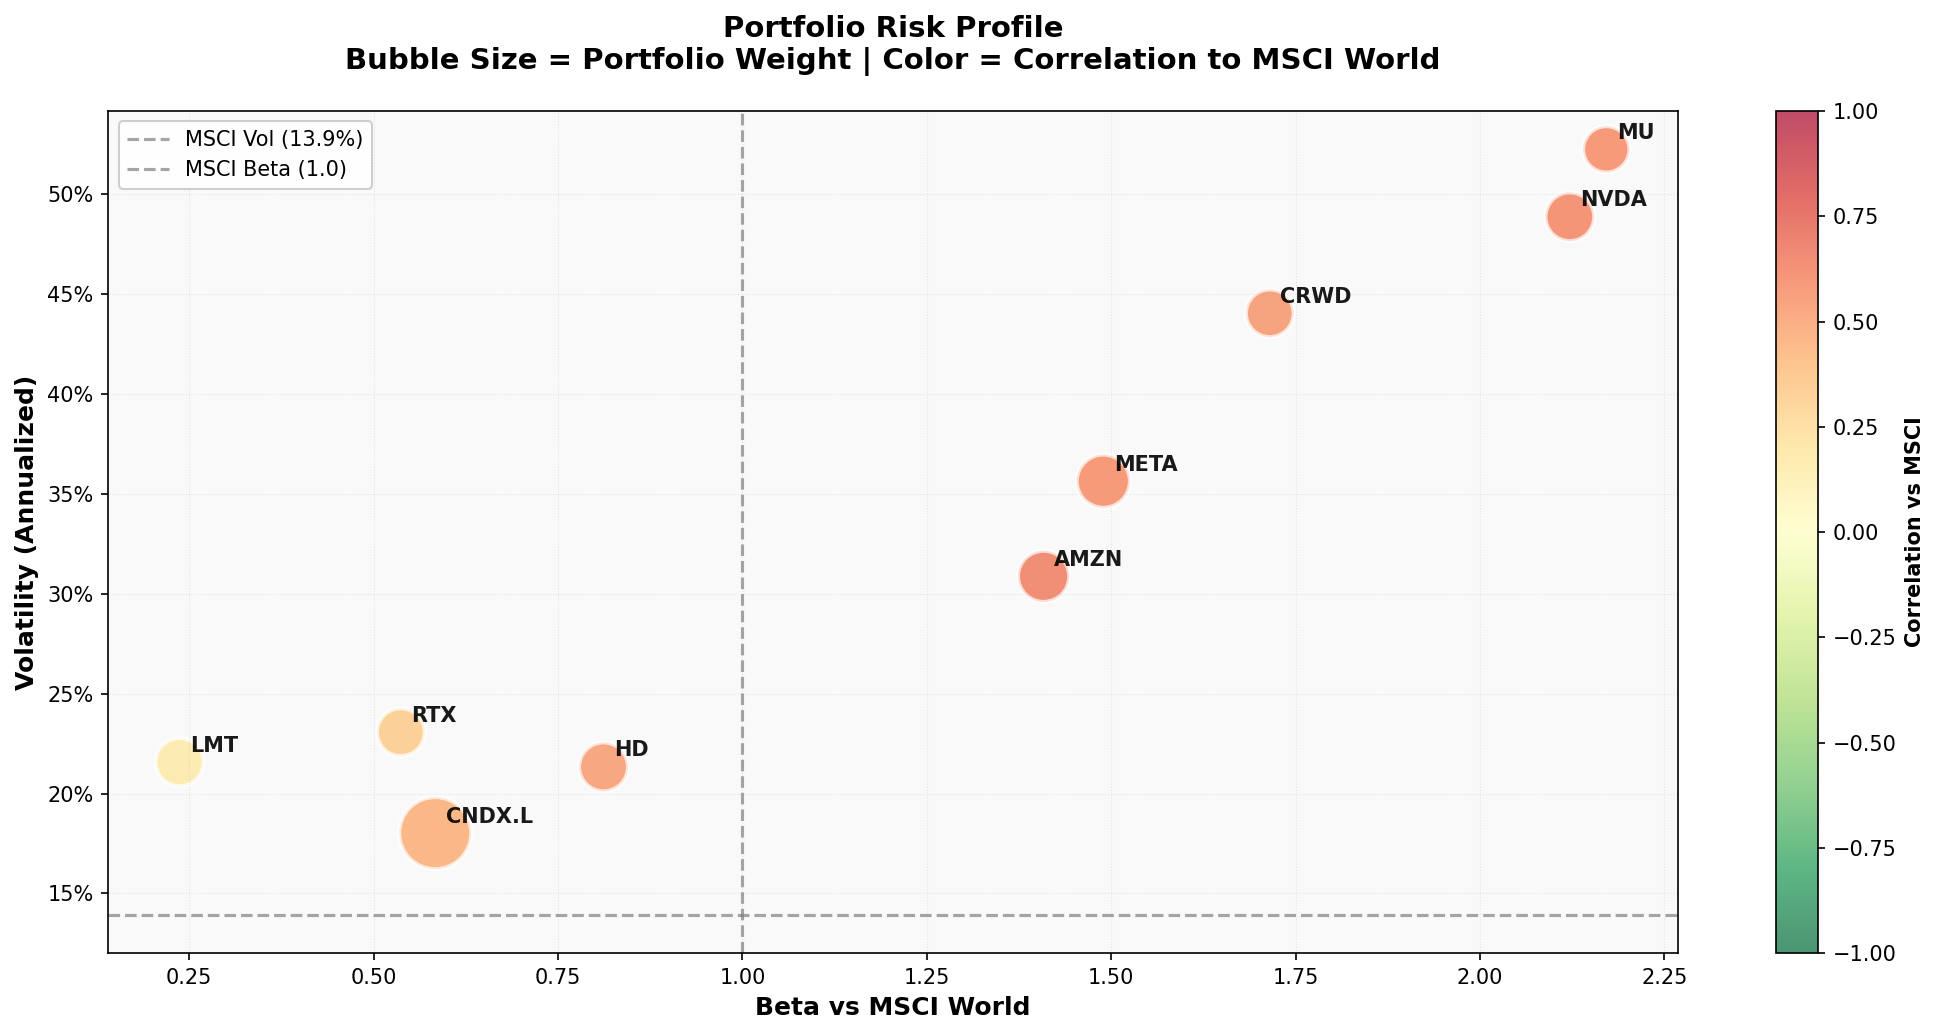

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare plot data
plot_data = risk_df.copy()
plot_data["Weight"] = plot_data["Ticker"].map(weights)

# Remove MSCI index (SWDA.L)
plot_data = plot_data[plot_data["Ticker"] != "SWDA.L"]

# Calculate MSCI benchmarks
bench = returns[benchmark]
msci_vol = bench.std() * np.sqrt(252)
msci_beta = 1.0

# Create figure with high DPI for quality
fig, ax = plt.subplots(figsize=(14, 7), dpi=150)

# Create scatter plot with bubble sizes based on weight
# Normalize weights for bubble sizing (0.3 to 2.5 inches)
sizes = (plot_data["Weight"] / plot_data["Weight"].max()) * 1000 + 200

# Color by correlation
colors = plot_data["Corr_vs_MSCI"]

scatter = ax.scatter(
    plot_data["Beta"], 
    plot_data["Vol"], 
    s=sizes,
    c=colors,
    cmap="RdYlGn_r",
    alpha=0.7,
    edgecolors="white",
    linewidth=2,
    vmin=-1,
    vmax=1
)

# Add ticker labels next to each bubble
for idx, row in plot_data.iterrows():
    ax.annotate(
        row["Ticker"],
        xy=(row["Beta"], row["Vol"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
        alpha=0.9
    )

# Add MSCI benchmark reference lines
ax.axhline(y=msci_vol, color="gray", linestyle="--", linewidth=1.5, alpha=0.7, label=f"MSCI Vol ({msci_vol:.1%})")
ax.axvline(x=msci_beta, color="gray", linestyle="--", linewidth=1.5, alpha=0.7, label=f"MSCI Beta ({msci_beta:.1f})")

# Labels and title
ax.set_xlabel("Beta vs MSCI World", fontsize=12, fontweight="bold")
ax.set_ylabel("Volatility (Annualized)", fontsize=12, fontweight="bold")
ax.set_title("Portfolio Risk Profile\nBubble Size = Portfolio Weight | Color = Correlation to MSCI World", 
             fontsize=14, fontweight="bold", pad=20)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Correlation vs MSCI", fontweight="bold")

# Grid and styling
ax.grid(True, alpha=0.3, linestyle=":", linewidth=0.5)
ax.set_facecolor("#f9f9f9")
fig.patch.set_facecolor("white")

# Legend
ax.legend(loc="best", fontsize=10, framealpha=0.95)

plt.tight_layout()



# Export as SVG and PNG
plt.savefig("../plots/portfolio_risk_profile.svg", format="svg", dpi=150, bbox_inches="tight")
plt.savefig("../plots/portfolio_risk_profile.png", format="png", dpi=150, bbox_inches="tight")
print("✓ Exported: portfolio_risk_profile.svg")
print("✓ Exported: portfolio_risk_profile.png")

# Display
plt.show()

In [42]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

holdings = ["SWDA.L","CNDX.L","AMZN","META","MU","RTX","NVDA","HD","LMT","CRWD"]
candidate = "LNG"

tickers = holdings + [candidate]

prices = yf.download(tickers, period="3y")["Close"]
rets = prices.pct_change().dropna()

[*********************100%***********************]  11 of 11 completed
C:\Users\Ale Leiva\AppData\Local\Temp\ipykernel_13304\1696096669.py:12: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [43]:
corr_returns = rets.corr()[candidate].drop(candidate).sort_values()
print("Return correlation (LNG vs holdings):")
print(corr_returns)

Return correlation (LNG vs holdings):
Ticker
CNDX.L    0.033516
SWDA.L    0.037162
AMZN      0.073805
META      0.105174
CRWD      0.135468
MU        0.148473
NVDA      0.162494
HD        0.164697
LMT       0.180070
RTX       0.237798
Name: LNG, dtype: float64


In [44]:
cum = (1 + rets).cumprod()
peak = cum.cummax()
dd = cum / peak - 1  # drawdown series

corr_dd = dd.corr()[candidate].drop(candidate).sort_values()
print("\nDrawdown correlation (LNG vs holdings):")
print(corr_dd)


Drawdown correlation (LNG vs holdings):
Ticker
RTX      -0.313063
MU       -0.257709
CRWD     -0.092157
CNDX.L   -0.017157
AMZN      0.075924
NVDA      0.126230
LMT       0.235332
HD        0.410637
META      0.445807
SWDA.L    0.626444
Name: LNG, dtype: float64


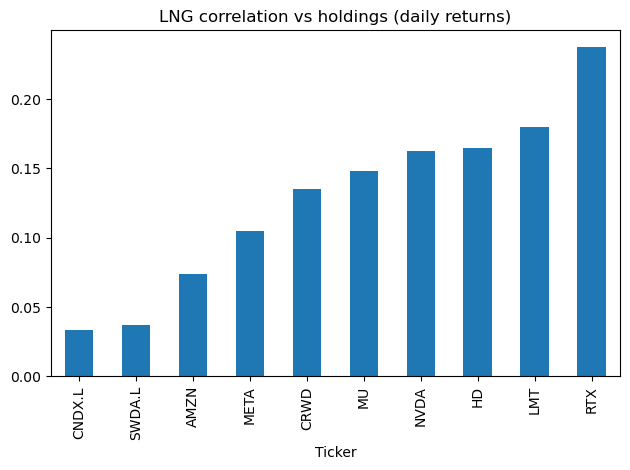

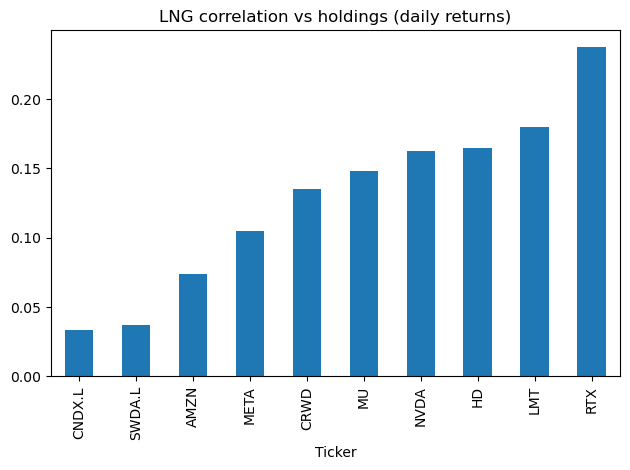

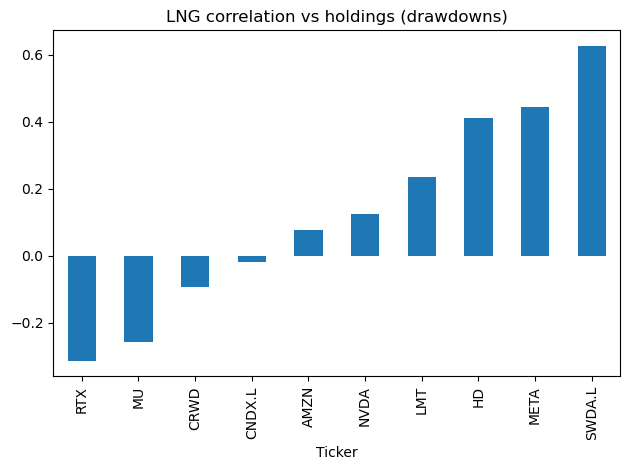

In [45]:
plt.figure()
corr_returns.plot(kind="bar")
plt.title("LNG correlation vs holdings (daily returns)")
plt.tight_layout()
plt.show()

plt.figure()
corr_dd.plot(kind="bar")
plt.title("LNG correlation vs holdings (drawdowns)")
plt.tight_layout()
plt.show()

In [46]:
weights = df.set_index("Slice")["Weight"]
weights.index = ["SWDA.L","CNDX.L","AMZN","META","MU","RTX","NVDA","HD","LMT","CRWD"]

avg_corr = float((corr_returns * weights.reindex(corr_returns.index)).sum())
avg_corr_dd = float((corr_dd * weights.reindex(corr_dd.index)).sum())

print("\nWeighted avg correlation to portfolio:")
print("Returns:", round(avg_corr, 3))
print("Drawdowns:", round(avg_corr_dd, 3))


Weighted avg correlation to portfolio:
Returns: 0.084
Drawdowns: 0.306


In [52]:
import yfinance as yf

ticker = yf.Ticker("LNG")
info = ticker.info

print("Market Cap:", info.get("marketCap"))
print("Forward PE:", info.get("forwardPE"))
print("Trailing PE:", info.get("trailingPE"))
print("Free Cash Flow:", info.get("freeCashflow"))
print("Debt:", info.get("totalDebt"))
print("Revenue:", info.get("totalRevenue"))

Market Cap: 48219320320
Forward PE: 15.329496
Trailing PE: 12.250698
Free Cash Flow: 1612499968
Debt: 26144000000
Revenue: 18936999936


# Stock Pitch: LNG

[*********************100%***********************]  1 of 1 completed
C:\Users\Ale Leiva\AppData\Local\Temp\ipykernel_13304\905470393.py:8: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



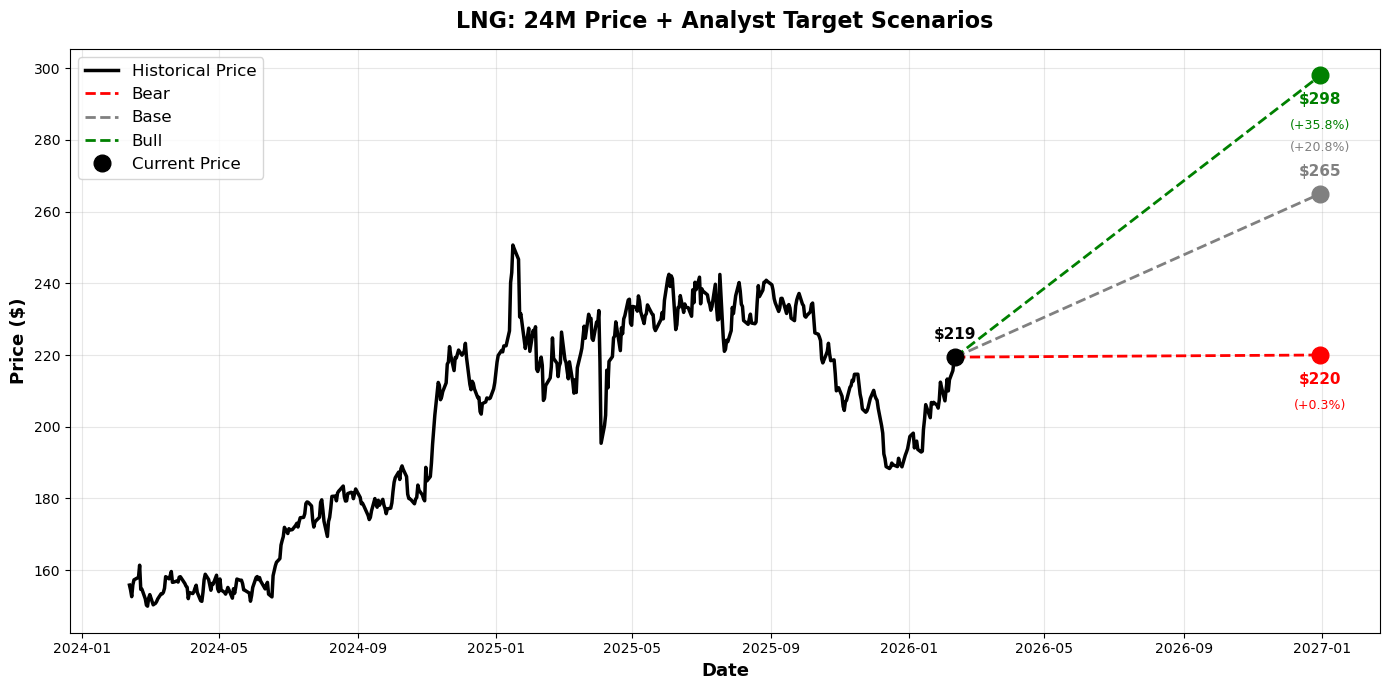

In [74]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

ticker = "LNG"
data = yf.download(ticker, period="24mo")["Close"].dropna()

current_price = float(data.iloc[-1])

bear, base, bull = 220, 265, 298

future_end = pd.Timestamp("2026-12-31")

# Calculate percentage changes
bear_pct = ((bear - current_price) / current_price) * 100
base_pct = ((base - current_price) / current_price) * 100
bull_pct = ((bull - current_price) / current_price) * 100

plt.figure(figsize=(14, 7))
plt.plot(data.index, data.values, label="Historical Price", linewidth=2.5, color='black')

# Plot projection lines
plt.plot([data.index[-1], future_end], [current_price, bear], "--", color="red", label="Bear", linewidth=2)
plt.plot([data.index[-1], future_end], [current_price, base], "--", color="gray", label="Base", linewidth=2)
plt.plot([data.index[-1], future_end], [current_price, bull], "--", color="green", label="Bull", linewidth=2)

# Add markers at current price and target prices
plt.plot(data.index[-1], current_price, 'o', markersize=12, color='black', zorder=5, label="Current Price")
plt.plot(future_end, bear, 'o', markersize=12, color='red', zorder=5)
plt.plot(future_end, base, 'o', markersize=12, color='gray', zorder=5)
plt.plot(future_end, bull, 'o', markersize=12, color='green', zorder=5)

# Add value labels with percentage changes
plt.text(data.index[-1], current_price + 5, f"${current_price:.0f}", ha='center', fontsize=11, fontweight='bold')
plt.text(future_end, bear - 8, f"${bear:.0f}", ha='center', fontsize=11, fontweight='bold', color='red')
plt.text(future_end, bear - 15, f"({bear_pct:+.1f}%)", ha='center', fontsize=9, color='red')
plt.text(future_end, base + 5, f"${base:.0f}", ha='center', fontsize=11, fontweight='bold', color='gray')
plt.text(future_end, base + 12, f"({base_pct:+.1f}%)", ha='center', fontsize=9, color='gray')
plt.text(future_end, bull - 8, f"${bull:.0f}", ha='center', fontsize=11, fontweight='bold', color='green')
plt.text(future_end, bull - 15, f"({bull_pct:+.1f}%)", ha='center', fontsize=9, color='green')

plt.title("LNG: 24M Price + Analyst Target Scenarios", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Date", fontsize=13, fontweight='bold')
plt.ylabel("Price ($)", fontsize=13, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../plots/lng_scenarios.png", dpi=300, bbox_inches="tight")
plt.show()

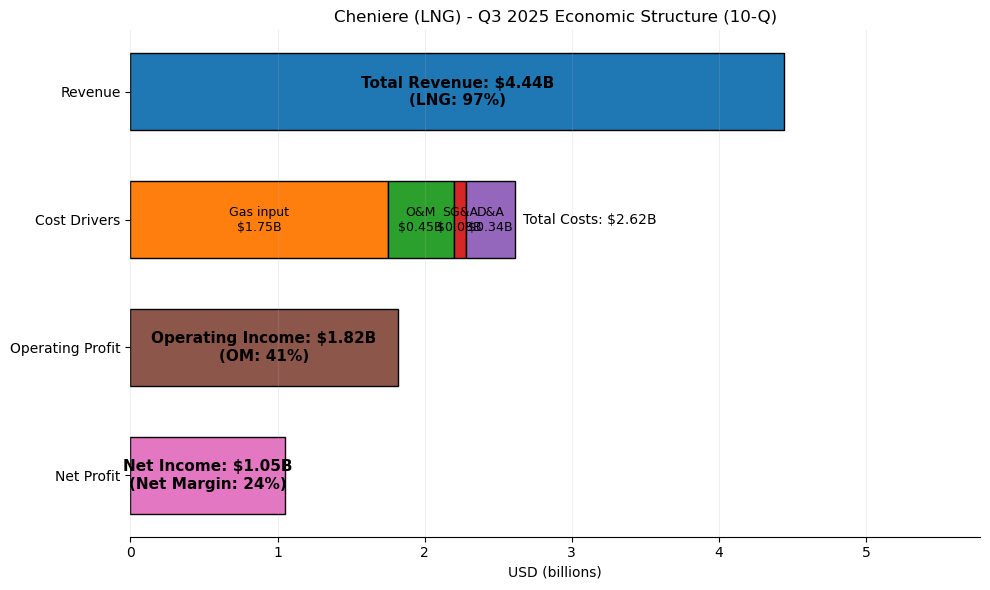

In [ ]:
import matplotlib.pyplot as plt

# --------- Q3 2025 (USD millions) ----------
rev_total = 4441
rev_lng = 4302
rev_other = rev_total - rev_lng

cost_gas = 1750
cost_om = 447
cost_sga = 81
cost_da = 338

op_income = 1817
net_income = 1049

# Convert to billions
to_bn = lambda x: x / 1000.0
R = to_bn(rev_total)
OI = to_bn(op_income)
NI = to_bn(net_income)

costs = {
    "Gas input": to_bn(cost_gas),
    "O&M": to_bn(cost_om),
    "SG&A": to_bn(cost_sga),
    "D&A": to_bn(cost_da),
}

# --------- Plot ----------
fig, ax = plt.subplots(figsize=(10, 6))

y_levels = [3, 2, 1, 0]  # Revenue, Costs, Operating, Net
h = 0.6

# Revenue
ax.barh(y_levels[0], R, height=h, edgecolor="black")
ax.text(R/2, y_levels[0],
        f"Total Revenue: ${R:.2f}B\n(LNG: {rev_lng/rev_total:.0%})",
        ha="center", va="center", fontsize=11, fontweight="bold")

# Costs (stacked)
left = 0
for k, v in costs.items():
    ax.barh(y_levels[1], v, left=left, height=h, edgecolor="black")
    ax.text(left + v/2, y_levels[1],
            f"{k}\n${v:.2f}B",
            ha="center", va="center", fontsize=9)
    left += v

ax.text(left + 0.05, y_levels[1],
        f"Total Costs: ${left:.2f}B",
        ha="left", va="center", fontsize=10)

# Operating Income
ax.barh(y_levels[2], OI, height=h, edgecolor="black")
ax.text(OI/2, y_levels[2],
        f"Operating Income: ${OI:.2f}B\n(OM: {op_income/rev_total:.0%})",
        ha="center", va="center", fontsize=11, fontweight="bold")

# Net Income
ax.barh(y_levels[3], NI, height=h, edgecolor="black")
ax.text(NI/2, y_levels[3],
        f"Net Income: ${NI:.2f}B\n(Net Margin: {net_income/rev_total:.0%})",
        ha="center", va="center", fontsize=11, fontweight="bold")

# Styling
ax.set_yticks(y_levels)
ax.set_yticklabels(["Revenue", "Cost Drivers", "Operating Profit", "Net Profit"])
ax.set_xlabel("USD (billions)")
ax.set_title("Cheniere (LNG) - Q3 2025 Economic Structure (10-Q)")
ax.set_xlim(0, R * 1.3)
ax.grid(axis="x", alpha=0.2)

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
#plt.savefig("../plots/lng_econ_funnel_with_net.png", dpi=300, bbox_inches="tight")
plt.show()

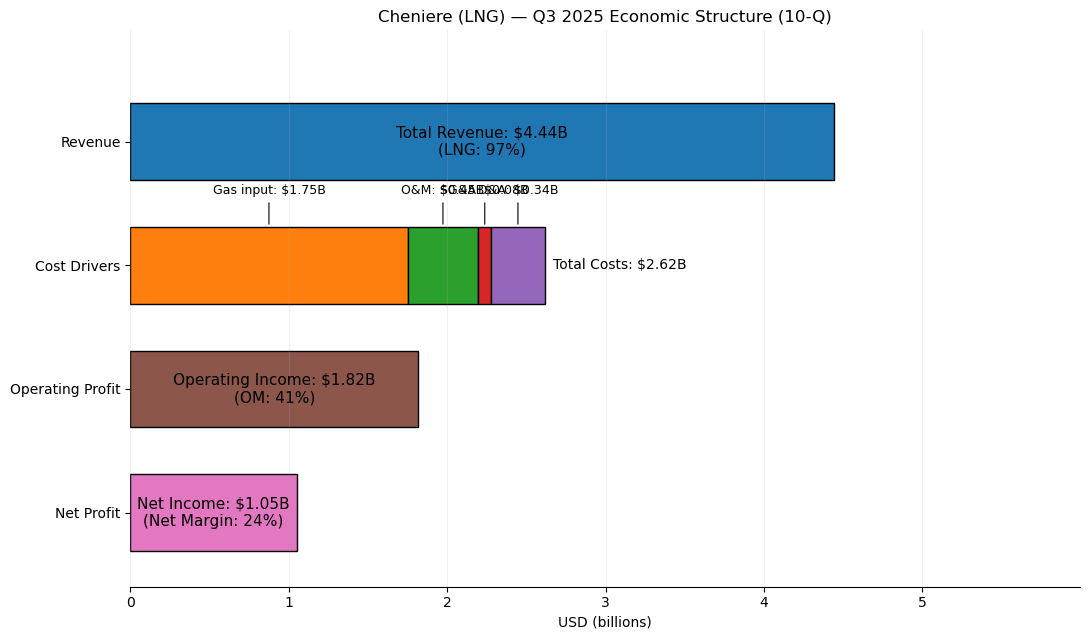

In [80]:
import matplotlib.pyplot as plt

# --------- Q3 2025 (USD millions) ----------
rev_total = 4441
rev_lng = 4302

cost_gas = 1750
cost_om = 447
cost_sga = 81
cost_da = 338

op_income = 1817
net_income = 1049

# Convert to billions
to_bn = lambda x: x / 1000.0
R = to_bn(rev_total)
OI = to_bn(op_income)
NI = to_bn(net_income)

costs = {
    "Gas input": to_bn(cost_gas),
    "O&M": to_bn(cost_om),
    "SG&A": to_bn(cost_sga),
    "D&A": to_bn(cost_da),
}

# --------- Plot ----------
fig, ax = plt.subplots(figsize=(11, 6.5))

y_levels = [3, 2, 1, 0]  # Revenue, Costs, Operating, Net
h = 0.62

# Revenue
ax.barh(y_levels[0], R, height=h, edgecolor="black", linewidth=1)
ax.text(
    R / 2, y_levels[0],
    f"Total Revenue: ${R:.2f}B\n(LNG: {rev_lng/rev_total:.0%})",
    ha="center", va="center", fontsize=11
)

# Costs (stacked bars, labels OUTSIDE with callouts)
left = 0
centers = []
widths = []
labels = []
for k, v in costs.items():
    ax.barh(y_levels[1], v, left=left, height=h, edgecolor="black", linewidth=1)
    centers.append(left + v / 2)
    widths.append(v)
    labels.append(k)
    left += v

# Place callouts above the cost bar
y_cost = y_levels[1]
y_text = y_cost + 0.55  # above the bar

for cx, w, k in zip(centers, widths, labels):
    ax.annotate(
        f"{k}: ${w:.2f}B",
        xy=(cx, y_cost + h/2),           # point on the bar
        xytext=(cx, y_text),             # text above
        ha="center", va="bottom",
        fontsize=9,
        arrowprops=dict(arrowstyle="-", lw=0.8)
    )

ax.text(
    left + 0.05, y_levels[1],
    f"Total Costs: ${left:.2f}B",
    ha="left", va="center", fontsize=10
)

# Operating Income
ax.barh(y_levels[2], OI, height=h, edgecolor="black", linewidth=1)
ax.text(
    OI / 2, y_levels[2],
    f"Operating Income: ${OI:.2f}B\n(OM: {op_income/rev_total:.0%})",
    ha="center", va="center", fontsize=11
)

# Net Income
ax.barh(y_levels[3], NI, height=h, edgecolor="black", linewidth=1)
ax.text(
    NI / 2, y_levels[3],
    f"Net Income: ${NI:.2f}B\n(Net Margin: {net_income/rev_total:.0%})",
    ha="center", va="center", fontsize=11
)

# Styling
ax.set_yticks(y_levels)
ax.set_yticklabels(["Revenue", "Cost Drivers", "Operating Profit", "Net Profit"])
ax.set_xlabel("USD (billions)")
ax.set_title("Cheniere (LNG) — Q3 2025 Economic Structure (10-Q)")
ax.set_xlim(0, R * 1.35)
ax.grid(axis="x", alpha=0.18)

for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

# Give room for cost callouts
ax.set_ylim(-0.6, 3.9)

plt.tight_layout()
plt.savefig("../plots/lng_econ_funnel_with_net_pretty.png", dpi=300, bbox_inches="tight")
plt.show()

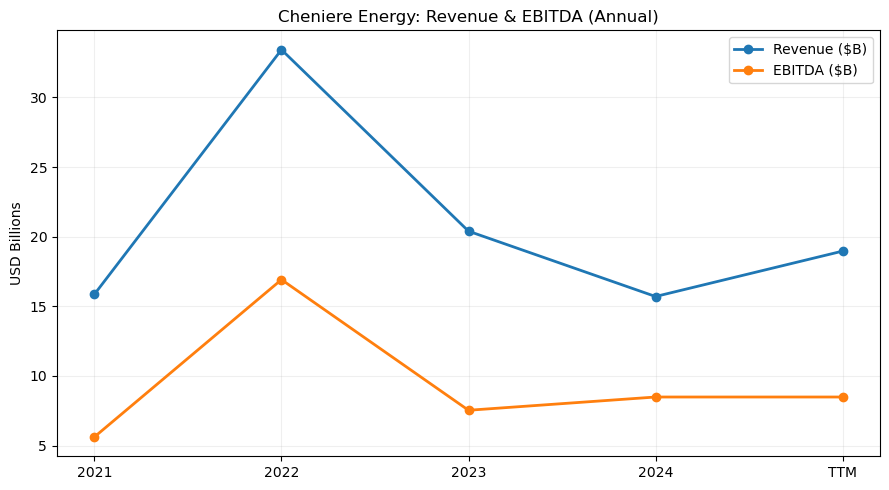

In [82]:
import matplotlib.pyplot as plt

years = ["2021", "2022", "2023", "2024", "TTM"]
revenue = [15.864, 33.428, 20.394, 15.703, 18.962]
ebitda = [5.619, 16.915, 7.533, 8.485, 8.485]

plt.figure(figsize=(9,5))

plt.plot(years, revenue, marker="o", linewidth=2, label="Revenue ($B)")
plt.plot(years, ebitda, marker="o", linewidth=2, label="EBITDA ($B)")

plt.title("Cheniere Energy: Revenue & EBITDA (Annual)")
plt.ylabel("USD Billions")
plt.grid(alpha=0.2)
plt.legend()

plt.tight_layout()
plt.savefig("../plots/lng_revenue_ebitda.png", dpi=300, bbox_inches="tight")
plt.show()

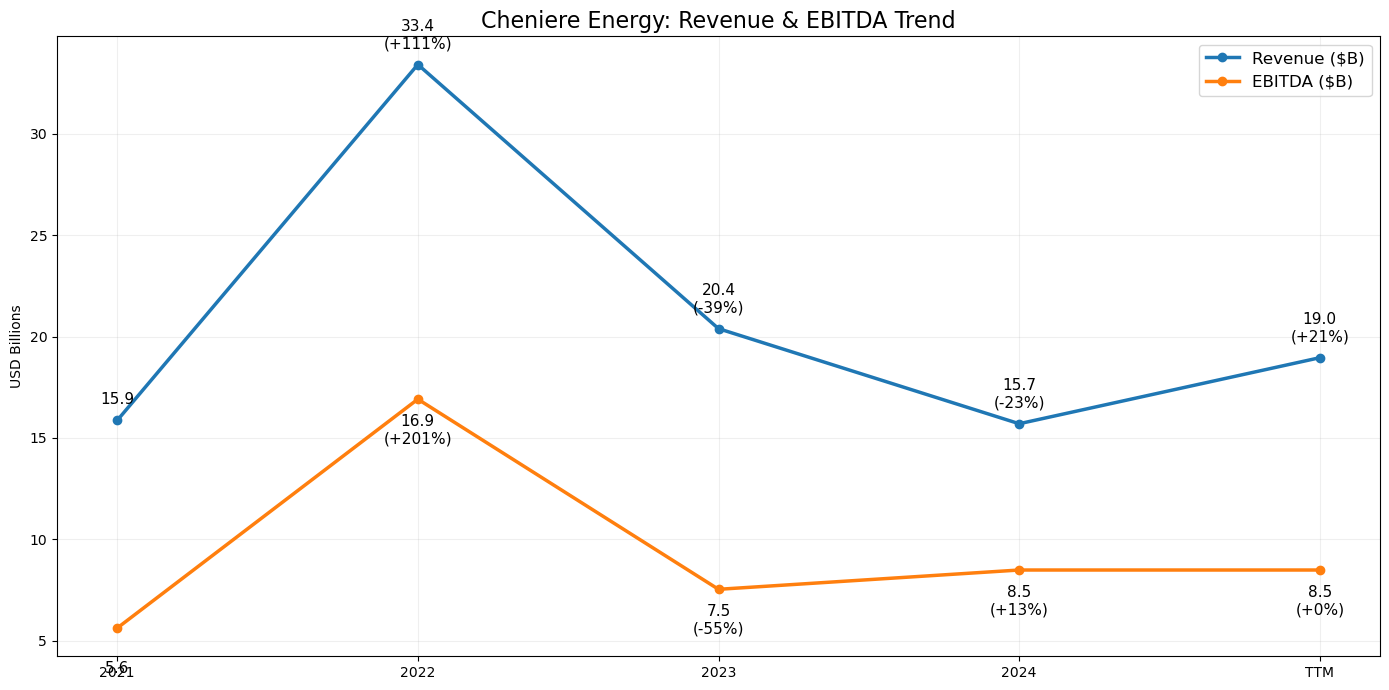

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Data
years = ["2021", "2022", "2023", "2024", "TTM"]
revenue = np.array([15.864, 33.428, 20.394, 15.703, 18.962])
ebitda = np.array([5.619, 16.915, 7.533, 8.485, 8.485])

# YoY calculations
rev_yoy = [None] + list((revenue[1:] / revenue[:-1] - 1) * 100)
ebitda_yoy = [None] + list((ebitda[1:] / ebitda[:-1] - 1) * 100)

# Plot
plt.figure(figsize=(14,7))

plt.plot(years, revenue, marker="o", linewidth=2.5, label="Revenue ($B)")
plt.plot(years, ebitda, marker="o", linewidth=2.5, label="EBITDA ($B)")

# Labels
for i, (x, y) in enumerate(zip(years, revenue)):
    if rev_yoy[i] is None:
        label = f"{y:.1f}"
    else:
        label = f"{y:.1f}\n({rev_yoy[i]:+.0f}%)"
    plt.text(i, y + 0.8, label, ha="center", fontsize=11)

for i, (x, y) in enumerate(zip(years, ebitda)):
    if ebitda_yoy[i] is None:
        label = f"{y:.1f}"
    else:
        label = f"{y:.1f}\n({ebitda_yoy[i]:+.0f}%)"
    plt.text(i, y - 2.2, label, ha="center", fontsize=11)

plt.title("Cheniere Energy: Revenue & EBITDA Trend", fontsize=16)
plt.ylabel("USD Billions")
plt.grid(alpha=0.2)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("../plots/lng_revenue_ebitda_yoy.png", dpi=300, bbox_inches="tight")
plt.show()

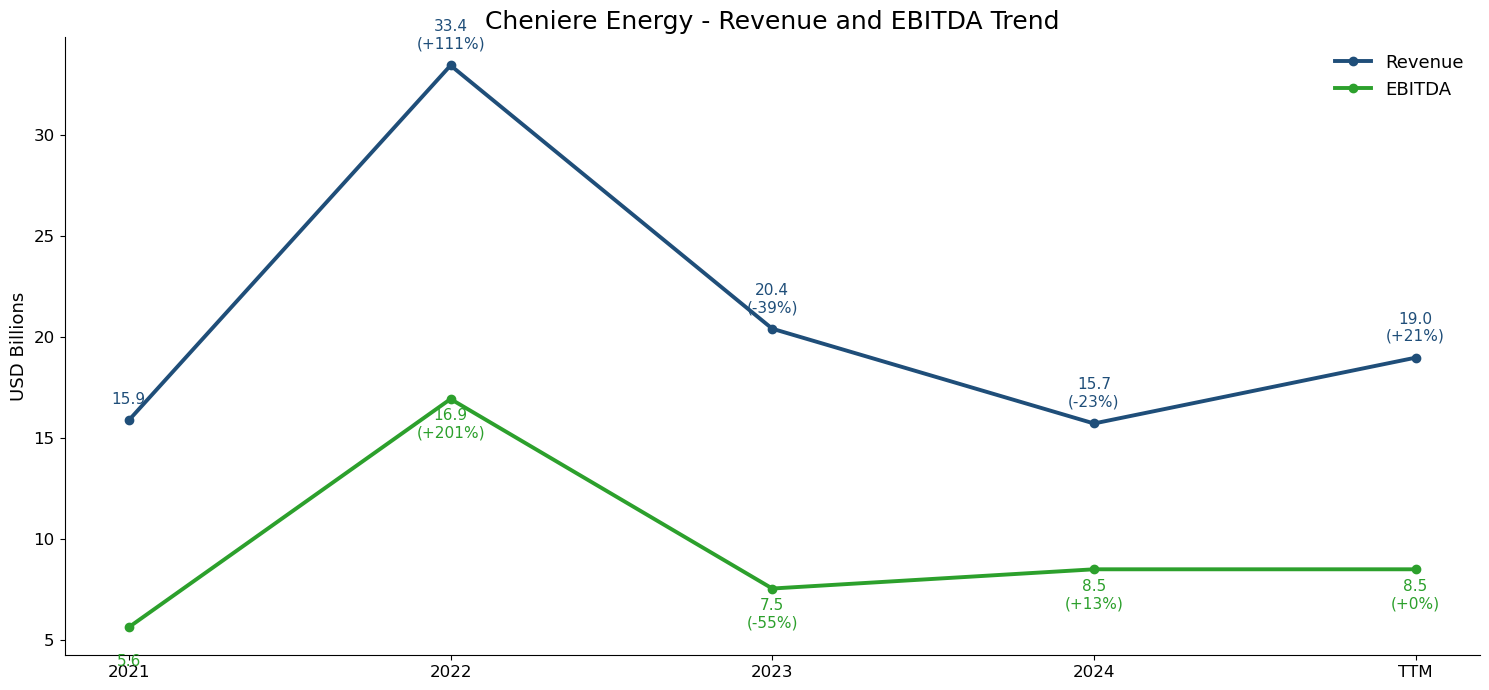

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Data (USD Billions)
# -------------------------
years = ["2021", "2022", "2023", "2024", "TTM"]
revenue = np.array([15.864, 33.428, 20.394, 15.703, 18.962])
ebitda = np.array([5.619, 16.915, 7.533, 8.485, 8.485])

# YoY %
rev_yoy = [None] + list((revenue[1:] / revenue[:-1] - 1) * 100)
ebitda_yoy = [None] + list((ebitda[1:] / ebitda[:-1] - 1) * 100)

# -------------------------
# Plot
# -------------------------
fig, ax = plt.subplots(figsize=(15,7))

# Institutional colors
rev_color = "#1f4e79"     # dark blue
ebitda_color = "#2ca02c"  # muted green

ax.plot(years, revenue, marker="o", linewidth=2.8, color=rev_color, label="Revenue")
ax.plot(years, ebitda, marker="o", linewidth=2.8, color=ebitda_color, label="EBITDA")

# -------------------------
# Labels
# -------------------------
for i in range(len(years)):
    # Revenue label above
    if rev_yoy[i] is None:
        text = f"{revenue[i]:.1f}"
    else:
        text = f"{revenue[i]:.1f}\n({rev_yoy[i]:+.0f}%)"
    ax.annotate(
        text,
        (years[i], revenue[i]),
        textcoords="offset points",
        xytext=(0,12),
        ha="center",
        fontsize=11,
        color=rev_color
    )

    # EBITDA label below
    if ebitda_yoy[i] is None:
        text = f"{ebitda[i]:.1f}"
    else:
        text = f"{ebitda[i]:.1f}\n({ebitda_yoy[i]:+.0f}%)"
    ax.annotate(
        text,
        (years[i], ebitda[i]),
        textcoords="offset points",
        xytext=(0,-28),
        ha="center",
        fontsize=11,
        color=ebitda_color
    )

# -------------------------
# Styling
# -------------------------
ax.set_title("Cheniere Energy - Revenue and EBITDA Trend", fontsize=18)
ax.set_ylabel("USD Billions", fontsize=13)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='both', labelsize=12)
ax.legend(frameon=False, fontsize=13)

plt.tight_layout()
plt.savefig("../plots/lng_revenue_ebitda_professional.png", dpi=300, bbox_inches="tight")
plt.show()

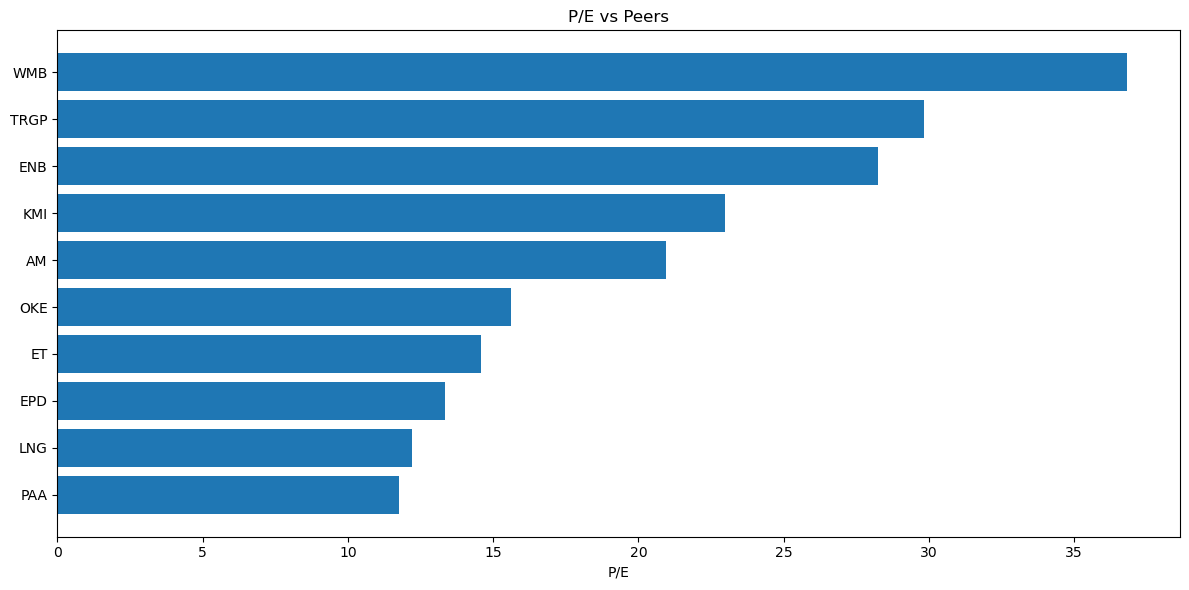

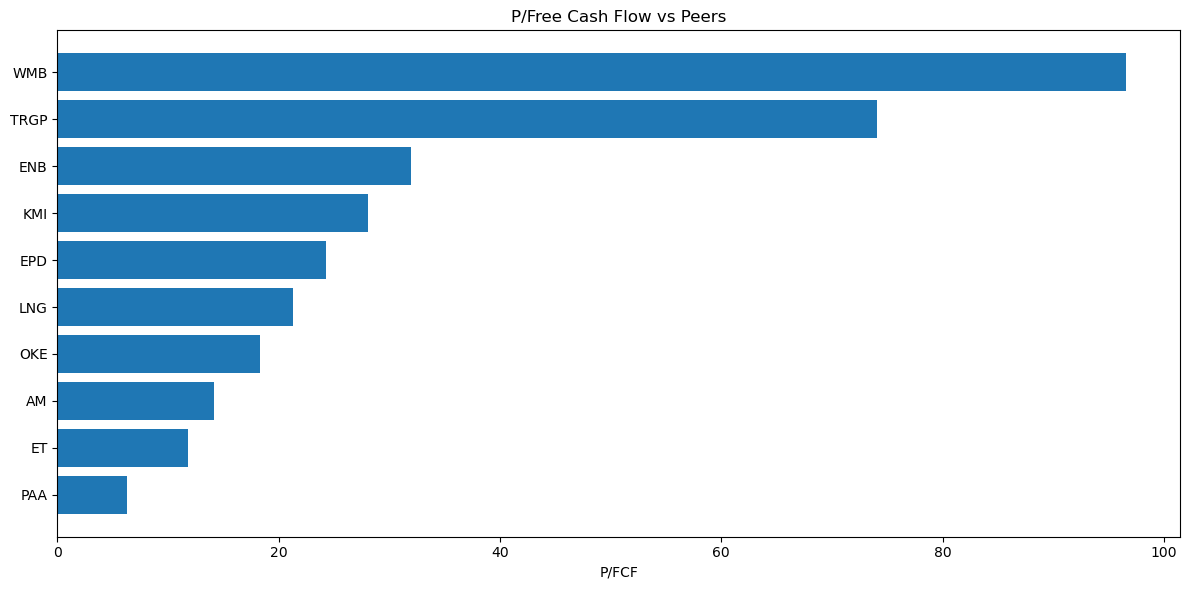

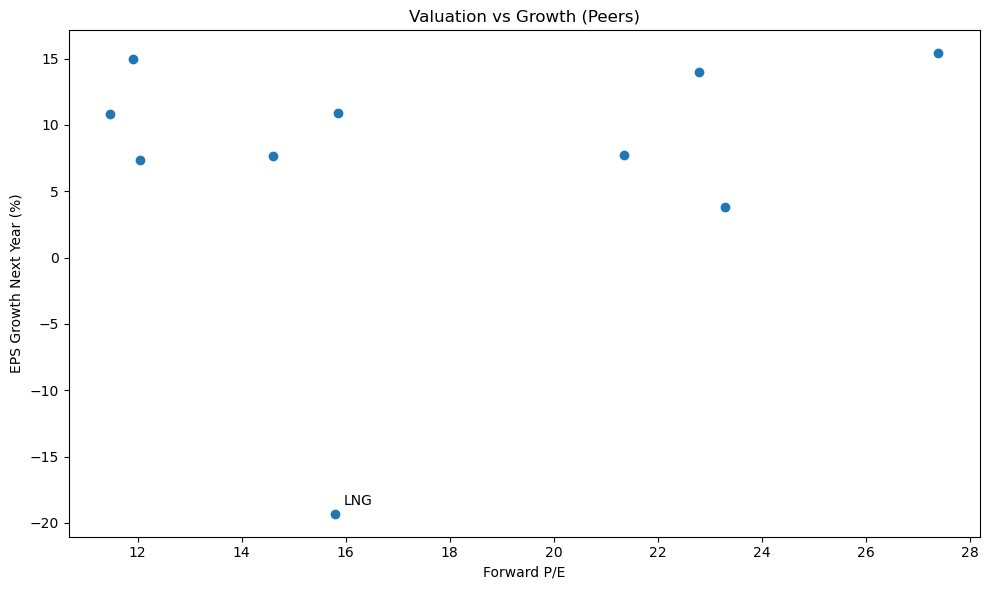

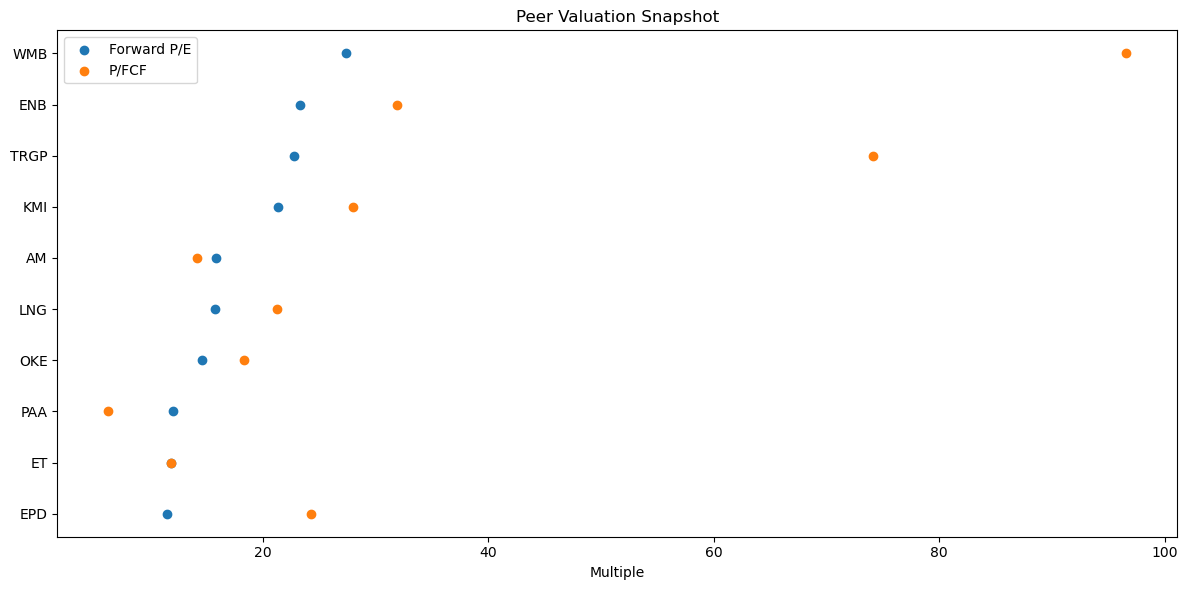

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/finviz.csv")

# ---- helpers: convert % strings to floats ----
def pct_to_float(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str) and "%" in x:
        return float(x.replace("%","").strip())
    return pd.to_numeric(x, errors="coerce")

df["FPE"] = pd.to_numeric(df["Forward P/E"], errors="coerce")
df["PFCF"] = pd.to_numeric(df["P/Free Cash Flow"], errors="coerce")
df["G_next"] = df["EPS Growth Next Year"].apply(pct_to_float)

# -----------------------------
# 1) Forward P/E ranking
# -----------------------------
tmp = df.sort_values("P/E", ascending=True).dropna(subset=["P/E"])
plt.figure(figsize=(12,6))
plt.barh(tmp["Ticker"], tmp["P/E"])
plt.title("P/E vs Peers")
plt.xlabel("P/E")
plt.tight_layout()
#plt.savefig("../plots/val_forward_pe.png", dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 2) P/Free Cash Flow ranking
# -----------------------------
tmp = df.sort_values("PFCF", ascending=True).dropna(subset=["PFCF"])
plt.figure(figsize=(12,6))
plt.barh(tmp["Ticker"], tmp["PFCF"])
plt.title("P/Free Cash Flow vs Peers")
plt.xlabel("P/FCF")
plt.tight_layout()
#plt.savefig("plots/val_pfcf.png", dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 3) Forward P/E vs Growth scatter
# -----------------------------
tmp = df.dropna(subset=["FPE","G_next"])
plt.figure(figsize=(10,6))
plt.scatter(tmp["FPE"], tmp["G_next"])
for _, r in tmp.iterrows():
    if r["Ticker"] == "LNG":
        plt.annotate("LNG", (r["FPE"], r["G_next"]), textcoords="offset points", xytext=(6,6))

plt.title("Valuation vs Growth (Peers)")
plt.xlabel("Forward P/E")
plt.ylabel("EPS Growth Next Year (%)")
plt.tight_layout()
#plt.savefig("plots/val_pe_vs_growth.png", dpi=300, bbox_inches="tight")
plt.show()

# -----------------------------
# 4) Two-metric dot plot (Forward P/E & P/FCF)
# -----------------------------
tmp = df[["Ticker","FPE","PFCF"]].dropna()
tmp = tmp.sort_values("FPE", ascending=True)

y = np.arange(len(tmp))
plt.figure(figsize=(12,6))
plt.scatter(tmp["FPE"], y, label="Forward P/E")
plt.scatter(tmp["PFCF"], y, label="P/FCF")
plt.yticks(y, tmp["Ticker"])
plt.title("Peer Valuation Snapshot")
plt.xlabel("Multiple")
plt.legend()
plt.tight_layout()
#plt.savefig("plots/val_snapshot_two_metrics.png", dpi=300, bbox_inches="tight")
plt.show()

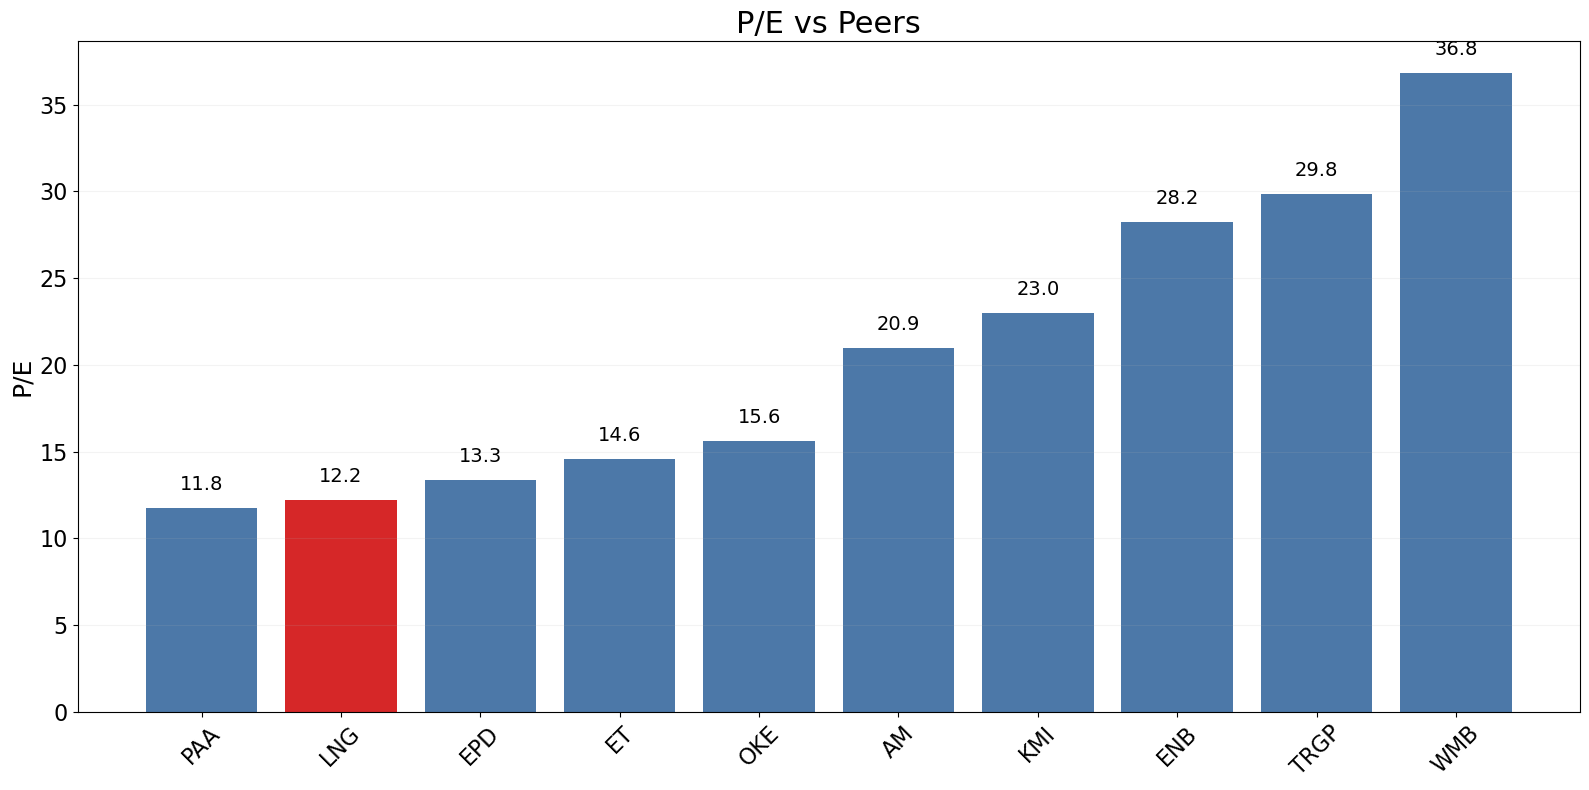

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/finviz.csv")
df["PE"] = pd.to_numeric(df["P/E"], errors="coerce")

tmp = df.sort_values("PE", ascending=True).dropna(subset=["PE"])

colors = ["#4c78a8" if t != "LNG" else "#d62728" for t in tmp["Ticker"]]

plt.figure(figsize=(16,8))
bars = plt.bar(tmp["Ticker"], tmp["PE"], color=colors)

# Bigger value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.8,
        f"{height:.1f}",
        ha='center',
        va='bottom',
        fontsize=14
    )

plt.title("P/E vs Peers", fontsize=22)
plt.ylabel("P/E", fontsize=18)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

plt.grid(axis="y", alpha=0.15)
plt.tight_layout()
plt.savefig("../plots/PE_peers.svg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
df = pd.read_csv("../data/finviz.csv")
df.columns


'Market Cap', 'P/E', 'Forward P/E', 'P/Free Cash Flow', 'EPS Growth This Year',
       'EPS Growth Next Year', 'EPS Growth Past 5 Years',
       'EPS Growth Next 5 Years', 'Sales Growth Past 5 Years'

Index(['No.', 'Ticker', 'Market Cap', 'P/E', 'Forward P/E', 'PEG', 'P/S',
       'P/B', 'P/Cash', 'P/Free Cash Flow', 'EPS Growth This Year',
       'EPS Growth Next Year', 'EPS Growth Past 5 Years',
       'EPS Growth Next 5 Years', 'Sales Growth Past 5 Years', 'Price',
       'Change', 'Volume'],
      dtype='object')

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load
df = pd.read_csv("../data/finviz.csv")

# Clean numeric columns
cols = ['Market Cap', "P/E", "Forward P/E", "P/Free Cash Flow", ]


def pct_to_float(x):
    if isinstance(x, str) and "%" in x:
        return float(x.replace("%",""))
    return pd.to_numeric(x, errors="coerce")

for c in cols:
    if c == "EPS Growth Next Year":
        df[c] = df[c].apply(pct_to_float)
    else:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Select columns
val_table = df[["Ticker"] + cols].copy()
val_table = val_table.sort_values("P/E")

# Round nicely
val_table = val_table.round(2)

print(val_table)

  Ticker  Market Cap    P/E  Forward P/E  P/Free Cash Flow
7    PAA    13954.75  11.77        12.05              6.30
5    LNG    47224.67  12.21        15.80             21.25
2    EPD    76689.73  13.35        11.47             24.25
3     ET    62521.97  14.58        11.91             11.84
6    OKE    53421.77  15.61        14.60             18.31
0     AM     9735.06  20.95        15.85             14.15
4    KMI    69968.72  22.97        21.36             28.03
1    ENB   112444.98  28.25        23.30             31.95
8   TRGP    47634.89  29.84        22.80             74.11
9    WMB    86853.09  36.80        27.40             96.61


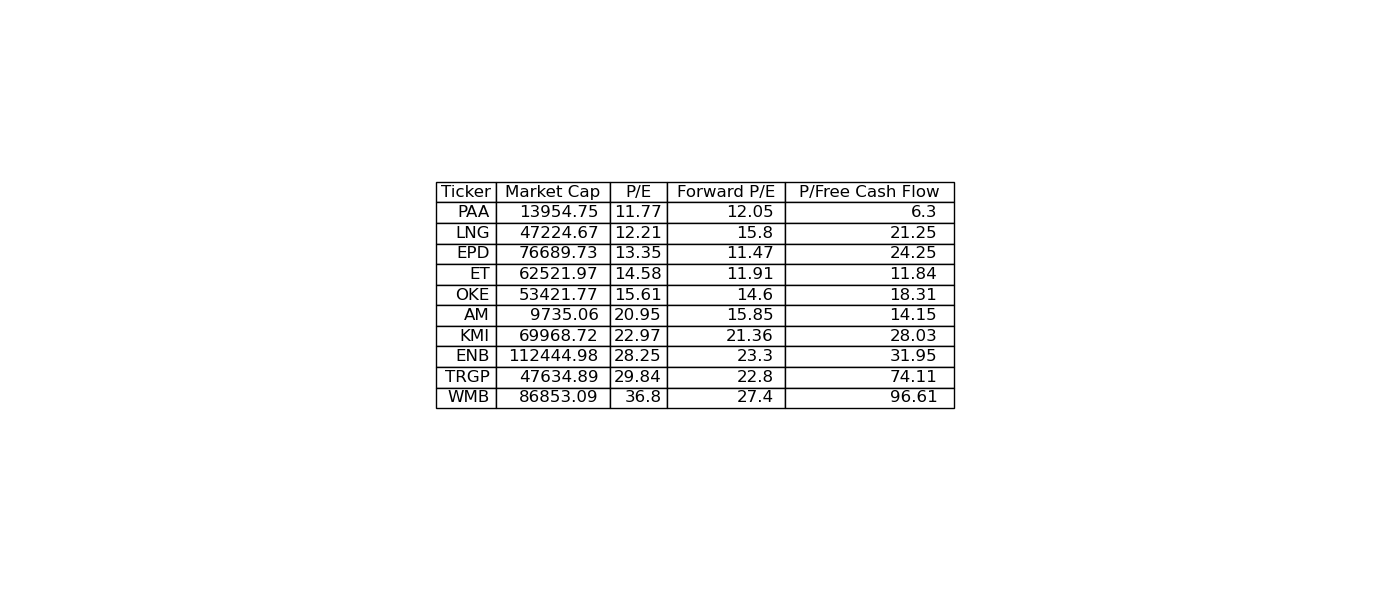

In [103]:
fig, ax = plt.subplots(figsize=(14,6))
ax.axis('off')

table = ax.table(
    cellText=val_table.values,
    colLabels=val_table.columns,
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(val_table.columns))))

plt.tight_layout()
plt.savefig("../plots/valuation_table.png", dpi=300, bbox_inches="tight")
plt.show()